In [1]:
import os
import pickle
import numpy

from music21 import note, chord
from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

2021-11-04 09:10:04.605918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-04 09:10:04.605976: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
""" 
    Esta sección define variables que se utilizarán en el programa y se crearán carpetas
    para almecenar diferentes tipos de archivos generados por el programa, cómo lo es, el modelo
    entrenado, una pista generada, etc.
"""
section = 'compose'
run_id = '0006'
music_name = 'cello'

directory = os.getcwd()

run_folder = os.path.join(directory,"run","section",'_'.join([run_id, music_name]))
store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.makedirs(run_folder)
    os.makedirs(os.path.join(run_folder, 'store'))
    os.makedirs(os.path.join(run_folder, 'output'))
    os.makedirs(os.path.join(run_folder, 'weights'))
    os.makedirs(os.path.join(run_folder, 'viz'))
    
mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [3]:
#Tranforma los datos a un formato más estructurado, separando la pista en los silencios, los acordes, las notas, etc.
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        #Desconpone la pista en acordes 
        original_score = parser.parse(file).chordify()
        
        for interval in intervals:
            score = original_score.transpose(interval)
            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)
            #Se verifica que tipo de entrada es (silencio, acorde, nota) y se almacena junto con su duration en dos lista (notes, durations)
            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)
                    
    #Crearemos o sobreescribiremos los archivos donde se almacenaras las notas y duraciones
    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
#En el caso de que no nos encontremos en modo "build", se cargarán los datos previamente almacenados
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

36 files in total
1 Parsing data/cello/cs1-1pre.mid
2 Parsing data/cello/cs1-2all.mid
3 Parsing data/cello/cs1-3cou.mid
4 Parsing data/cello/cs1-4sar.mid
5 Parsing data/cello/cs1-5men.mid
6 Parsing data/cello/cs1-6gig.mid
7 Parsing data/cello/cs2-1pre.mid
8 Parsing data/cello/cs2-2all.mid
9 Parsing data/cello/cs2-3cou.mid
10 Parsing data/cello/cs2-4sar.mid
11 Parsing data/cello/cs2-5men.mid
12 Parsing data/cello/cs2-6gig.mid
13 Parsing data/cello/cs3-1pre.mid
14 Parsing data/cello/cs3-2all.mid
15 Parsing data/cello/cs3-3cou.mid
16 Parsing data/cello/cs3-4sar.mid
17 Parsing data/cello/cs3-5bou.mid
18 Parsing data/cello/cs3-6gig.mid
19 Parsing data/cello/cs4-1pre.mid
20 Parsing data/cello/cs4-2all.mid
21 Parsing data/cello/cs4-3cou.mid
22 Parsing data/cello/cs4-4sar.mid
23 Parsing data/cello/cs4-5bou.mid
24 Parsing data/cello/cs4-6gig.mid
25 Parsing data/cello/cs5-1pre.mid
26 Parsing data/cello/cs5-2all.mid
27 Parsing data/cello/cs5-3cou.mid
28 Parsing data/cello/cs5-4sar.mid
29 Parsing 

In [4]:
#Se crean las tablas de búsqueda
#Con get_distinct() obtiene los distintos conjuntos de notas y duraciones
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

#Crea los diccionarios de búsqueda para notas, diccionarios y guarda
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [5]:
#imprime las notas
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B-3': 2,
 'A2.B2': 3,
 'A2.C3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.C#4': 32,
 'A3.B3.C#4.D4': 33,
 'A3.B3.C4': 34,
 'A3.C#4': 35,
 'A3.C#4.E4': 36,
 'A3.C4': 37,
 'A3.D4': 38,
 'A3.E4': 39,
 'A3.E4.F#4': 40,
 'A3.E4.G4': 41,
 'A3.F#4': 42,
 'A3.F#4.G4': 43,
 'A3.F4': 44,
 'A3.G4': 45,
 'A4': 46,
 'A4.B4': 47,
 'B-2': 48,
 'B-2.A3': 49,
 'B-2.B-3': 50,
 'B-2.C3': 51,
 'B-2.D3': 52,
 'B-2.D3.A3': 53,
 'B-2.D3.E-3.G#3': 54,
 'B-2.D3.G#3': 55,
 'B-2.E-3': 56,
 'B-2.E3': 57,
 'B-2.E3.D4': 58,
 'B-2.F#3.C#4.E4': 59,
 'B-2.F3': 60,
 'B-2.F

In [6]:
#Se muestran las duraciones
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 0.5: 5,
 Fraction(2, 3): 6,
 0.75: 7,
 1.0: 8,
 1.25: 9,
 Fraction(4, 3): 10,
 1.5: 11,
 1.75: 12,
 2.0: 13,
 2.5: 14,
 3.0: 15,
 4.0: 16}

In [7]:
#Se prepara las secuencias utilizadas por la red neuronal
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [8]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469 469
 469 469 469 469 469 469 469 469 469 469 469 469 469 469]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [12]:
#Crea la arquitectura de la red neuronal y se muestra un resumen de las capas.
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    47000       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 100)    1700        input_4[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.9/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


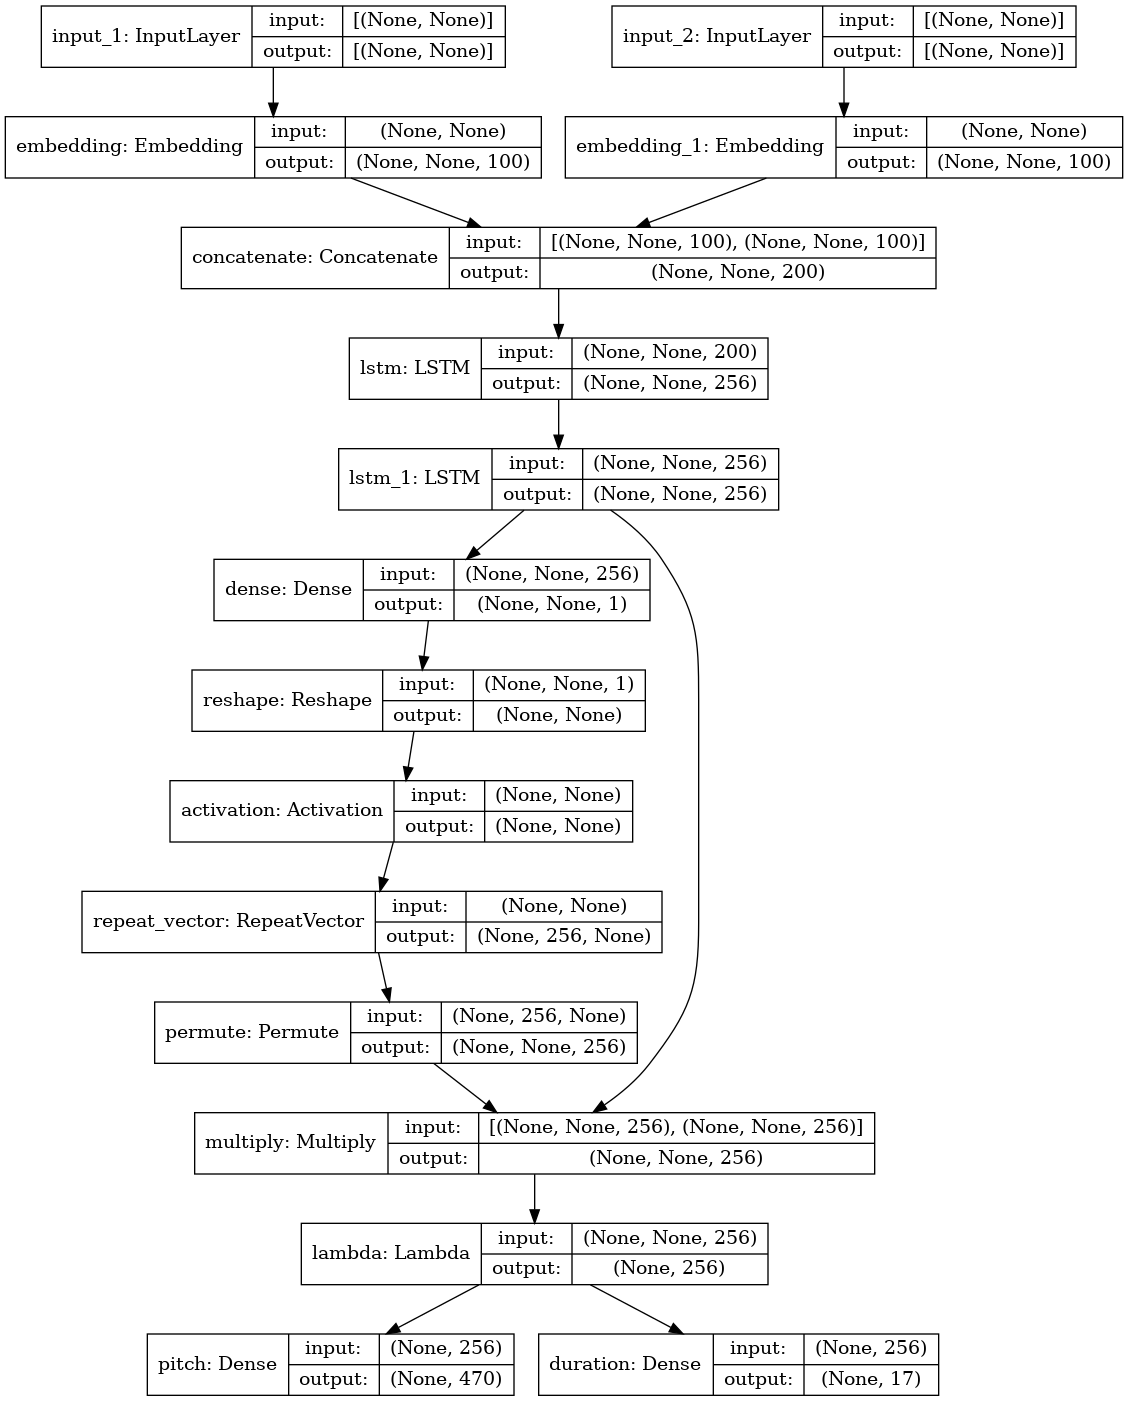

In [10]:
# Gráfica la arquitectura de la red
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

In [13]:
#Se entrena la red neuronal
#Se actualizan los pesos, tiene puntos de control y un alto anticipado para detener el entrenamiento cuando se podría llegar a un sobreajuste

weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=50, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/50
714/714 [==============================] - 232s 320ms/step - loss: 4.0932 - pitch_loss: 3.3494 - duration_loss: 0.7439 - val_loss: 6.0837 - val_pitch_loss: 5.2096 - val_duration_loss: 0.8741
Epoch 2/50
714/714 [==============================] - 212s 297ms/step - loss: 3.6860 - pitch_loss: 3.1222 - duration_loss: 0.5638 - val_loss: 6.0970 - val_pitch_loss: 5.2349 - val_duration_loss: 0.8621
Epoch 3/50
714/714 [==============================] - 193s 271ms/step - loss: 3.4682 - pitch_loss: 2.9645 - duration_loss: 0.5037 - val_loss: 5.9818 - val_pitch_loss: 5.1522 - val_duration_loss: 0.8297
Epoch 4/50
714/714 [==============================] - 223s 313ms/step - loss: 3.2827 - pitch_loss: 2.8303 - duration_loss: 0.4524 - val_loss: 6.3141 - val_pitch_loss: 5.5239 - val_duration_loss: 0.7902
Epoch 5/50
714/714 [==============================] - 335s 469ms/step - loss: 3.1350 - pitch_loss: 2.7207 - duration_loss: 0.4143 - val_loss: 6.2256 - val_pitch_loss: 5.4195 - val_duration_los

KeyboardInterrupt: 